In [1]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt

import scipy

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

pykat.init_pykat_plotting(fmts=['svg'])

%run LHO.py

base = make_LHO()
base.sFI_OM1.L += 0.2

def single_bounce_SQZ(base, direction = 'x', verbose=True, to_node='nAS'):
    """
    This does a single bounce trace off of SRM HR surface from the OPO beam.
    This happens in two parts. Once trace from the OPO to the SRM HR
    a refl off of SRM HR, and then a trace from this reflected beam to
    the requested node.
    
    Returns the final q value going in to the OMC
    """
    SQZqx = base.sqz.nSQZ.qx 
    SQZqy = base.sqz.nSQZ.qy
    
    if direction == 'y':
        qin = SQZqy
    else:
        qin = SQZqx

    SQZ2SRM = base.beamTrace(qin, "nSQZ", "nSRMs1", direction=direction)
    
    #ITMX substrate
    n = base.SRMsub.n.value

    # Manually calculate the reflection off of SRM HR inside substrate
    q2 = pykat.optics.ABCD.apply(base.SRM.ABCD("nSRMs1", "nSRMs1", direction=direction),
                                 SQZ2SRM.q_out,
                                 n, n)

    if to_node != "nSRMs1":
        SRM2OMC = base.beamTrace(q2, "nSRMs1", to_node, direction=direction)

        if verbose:
            SQZ2SRM.print()
            SRM2OMC.print()

        return pykat.BeamParam(q=SRM2OMC.q_out)
    else:
        if verbose:
            SQZ2SRM.print()
        
        return pykat.BeamParam(q=SQZ2SRM.q_out)
    
def SRM_HR_substrate_refl(qix, qiy):
    qx = pykat.optics.ABCD.apply(kat.SRM.ABCD("nSRMs1", "nSRMs1", direction='x'),
                                     qix, kat.SRMsub.n.value, kat.SRMsub.n.value)
    qy = pykat.optics.ABCD.apply(kat.SRM.ABCD("nSRMs1", "nSRMs1", direction='y'),
                                     qiy, kat.SRMsub.n.value, kat.SRMsub.n.value)
    
    return qx, qy

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat


Pykat parsing does not preserve inline comments. Moving inline
comments before command



In [2]:
## New lens measurements
# Distance
# x diameter
# y diameter
# x std dev
# y std dev

OPO_new       = np.array([[29.75*25.4e-3, 40.5*25.4e-3, 2.875*25.4e-3, (1.5+25.5+69.75+35.25) * 25.4e-3],
                          [1212e-6,        1228e-6,      1367e-6,      3428e-6],
                          [1187e-6,        1242e-6,      1392e-6,      3299e-6],
                          [5e-6,              5e-6,            5e-6,            15e-6],
                          [5e-6,              5e-6,            5e-6,            19e-6],])


HAM5_OMC      = np.array([[-53.375*25.4e-3, -52.125*25.4e-3,  -19.375*25.4e-3,   35.0625 * 25.4e-3  , 36.75*25.4e-3                      ],
                          [ 2666e-6,        2556e-6,           1861e-6,          935e-6             , 949e-6                    ],
                          [ 2236e-6,        2165e-6,           1496e-6,          1121e-6            , 1154e-6                   ],
                          [ 2e-6,              2e-6,              2e-6,          4e-6               , 3e-6                  ],
                          [ 4e-6,            1.4e-6,              3e-6,          3e-6               , 2e-6                 ],])

# Bad HAM5_OMC data point removed
# 33*25.4e-3,
# 1057e-6   ,
# 1129e-6   ,
#   18e-6   ,
#   17e-6   ,

# Measured relative to 1st steering mirror on OMC refl path
OMC_REFL_new  = np.array([
    [(22.75 + 22.25) * 25.4e-3, (24.375 + 22.25) * 25.4e-3 ],
    [2564e-6, 2625e-6],
    [2096e-6, 2157e-6],
    [30e-6, 20e-6],
    [23e-6, 36e-6]
])

qSRM_design = pykat.BeamParam(z=-3.55, w0=680e-6)

kat = base.deepcopy()

# Lens offset fits from original lens data.
dz1 =-0.00601394
dz2 = 0.00736888

kat.sqz_lens1.f = 250e-3 * 1/abs(1-kat.constants['nsilica'].value)
kat.sqz_lens2.f = 350e-3 * 1/abs(1-kat.constants['nsilica'].value)

# Double OM3 to OMC path as it travels that kind of 
# distance again to get to first steering mirror
OMC1_2_OMC_REFL_ST1 = kat.sOM1_OM2.L + kat.sOM2_OM3.L + kat.sOM3_OMC.L * 2
OMC_REFL_new[0, :] += OMC1_2_OMC_REFL_ST1

# add to data relative to OM1
HAM5_OMC = np.hstack((HAM5_OMC, OMC_REFL_new))

# Get the OMC mode at the SRM
qOMCx, qOMCy = kat.cavOMC.trace_to_node('nSRM2')
qOMCx.reverse()
qOMCy.reverse()

In [3]:
def fit_input_q(qguess, z_data, w_data, eps_data, z_ref=None):
    from lmfit import minimize, Parameters
    
    qguess = pykat.BeamParam(q=complex(qguess))
    
    def residual(params, kat, z, data, eps_data):
        q0 = pykat.BeamParam(z=params['z0'], w0=params['w0'])
        T = kat.beamTrace(q0, 'nSRM2', 'nOMC_ICa')
        model = T.beamsize(z, z_ref=z_ref)

        return (data-model) / eps_data

    params = Parameters()
    params.add('w0', value=qguess.w0, min=0)
    params.add('z0', value=qguess.z)

    out = minimize(residual, params, args=(kat, z_data, w_data, eps_data))

    qFIT = pykat.BeamParam(z=out.params['z0'], w0=out.params['w0'])

    return qFIT, out

sel = slice(None,None, None)
zdata = HAM5_OMC[0,sel]
xdata = HAM5_OMC[1,sel]/2
ydata = HAM5_OMC[2,sel]/2
xsig  = HAM5_OMC[3,sel]/2
ysig  = HAM5_OMC[0,sel]/2

qFITx,_ = fit_input_q(qSRM_design, zdata, xdata, xsig, z_ref="OM1")
qFITy,_ = fit_input_q(qSRM_design, zdata, ydata, ysig, z_ref="OM1")

TFITx = kat.beamTrace(qFITx, 'nSRM2', 'nOMC_ICa')
TFITy = kat.beamTrace(qFITy, 'nSRM2', 'nOMC_ICa')

Text(0.5,1,'OMC overlap x=0.83, y=0.95, avg=0.89')

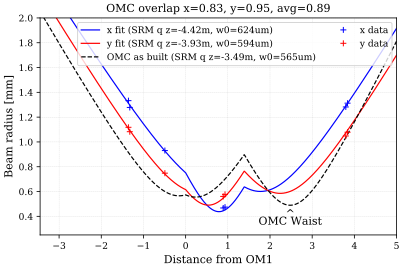

In [4]:
plt.figure(figsize=(4*1.6, 4))

z = np.linspace(-3.45, 5, 1000)

Tx = kat.beamTrace(qOMCx, 'nSRM2', 'nOMC_ICa')
Ty = kat.beamTrace(qOMCy, 'nSRM2', 'nOMC_ICa')

def plot_data(sel, var):
    zdata = var[0,sel]
    xdata = var[1,sel]/2
    ydata = var[2,sel]/2
    xsig  = var[3,sel]/2
    ysig  = var[0,sel]/2

    plt.errorbar(zdata, xdata/1e-3, yerr=xsig, marker='+',lw=0,c='b', label='x data')
    plt.errorbar(zdata, ydata/1e-3, yerr=ysig, marker='+',lw=0,c='r', label='y data')
    
plot_data(slice(None,None,None), HAM5_OMC)

plt.plot(z, TFITx.beamsize(z, "OM1")/1e-3, label='x fit (SRM q z=%.3gm, w0=%.3gum)' % (qFITx.z, qFITx.w0/1e-6))
plt.plot(z, TFITy.beamsize(z, "OM1")/1e-3, label='y fit (SRM q z=%.3gm, w0=%.3gum)' % (qFITy.z, qFITy.w0/1e-6))
plt.plot(z,    Tx.beamsize(z, "OM1")/1e-3, label='OMC as built (SRM q z=%.3gm, w0=%.3gum)' % (qOMCx.z, qOMCx.w0/1e-6), ls='--', c='k')

plt.xlabel("Distance from OM1")
plt.ylabel("Beam radius [mm]")
plt.legend(ncol=2, loc="upper right")
plt.ylim(0.25, 2)

ox, oy = (pykat.BeamParam.overlap(qOMCx, qFITx), pykat.BeamParam.overlap(qOMCy, qFITy))

plt.text(z[Tx.beamsize(z, "OM1").argmin()], 0.4, "OMC Waist", horizontalalignment='center', verticalalignment='top')
plt.text(z[Tx.beamsize(z, "OM1").argmin()], 0.46, "^", horizontalalignment='center', verticalalignment='top')
plt.title("OMC overlap x=%.2g, y=%.2g, avg=%.2g" % (ox,oy,(ox+oy)/2))


In [10]:
kat.beamTrace??

BasePyKatException: Did not handle component sqz correctly, has more or less than 2 nodes.

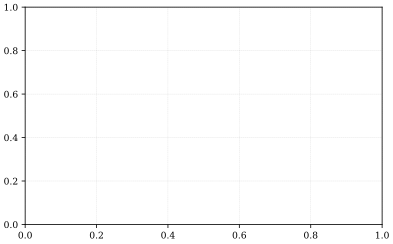

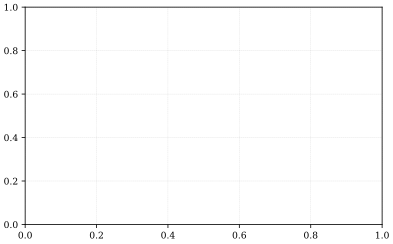

In [5]:
fig = plt.figure(figsize=(4*1.6, 4))
ax = plt.subplot(111)

fig2 = plt.figure(figsize=(4*1.6, 4))
ax2 = plt.subplot(111)


# dz1 =-0.00601394 -0.02
# dz2 = 0.00736888 + 0.02

# kat.sqz_lens1.f = 250e-3 * 0.98/abs(1-kat.constants['nsilica'].value)
# kat.sqz_lens2.f = 350e-3 * 1/abs(1-kat.constants['nsilica'].value)


# Get cavity OMC q at SRM...
OMCqx, OMCqy = kat.cavOMC.trace_to_node('nSRM2')
OMCqx.reverse()
OMCqy.reverse()

# Then trace it back to get the beam shape
trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",direction='x')
trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",direction='y')

lens2_pos = 0.5
c = 'g'
pos = 'prediction'

#shift_lenses(kat, 0, lens2_pos)
kat.data['fn_OPO_shift_lenses'](kat, dz1, lens2_pos, dz2)

trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs1",direction='x')
trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs1",direction='y')

qx, qy = SRM_HR_substrate_refl(trace_SQZ_SRMx.q_out, trace_SQZ_SRMy.q_out)

trace_SRM_HR_ARx = kat.beamTrace(qx, 'nSRMs1', "nSRM2",direction='x')
trace_SRM_HR_ARy = kat.beamTrace(qy, 'nSRMs1', "nSRM2",direction='y')

trace_SRM_OMCx = kat.beamTrace(trace_SRM_HR_ARx.q_out, 'nSRM2', "nOMC_REFL",direction='x')
trace_SRM_OMCy = kat.beamTrace(trace_SRM_HR_ARy.q_out, 'nSRM2', "nOMC_REFL",direction='y')

trace_SQZ_SRMx.plot_beamsize(ax=ax, color='b', label= 'x ' + pos, ls='--')
trace_SQZ_SRMy.plot_beamsize(ax=ax, color='r', label='y ' + pos, ls='--')
trace_SRM_OMCx.plot_beamsize(ax=ax2, color='b', label='x ' + pos, ls='--')
trace_SRM_OMCy.plot_beamsize(ax=ax2, color='r', label='y ' +pos, ls='--')

print(pos, "x", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
print(pos, "y", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

OMC_waist_pos = trace_OMCx.data['OM3']['z'] + 0.117 + 0.2 + 0.141
ZM1_pos = trace_SQZ_SRMx.data['ZM1']['z']

# Factor of two because measurement in diameter
ax.scatter(ZM1_pos + OPO_new[0,:], OPO_new[1,:]/2e-3, color='b', marker='x', label='x data')
ax.scatter(ZM1_pos + OPO_new[0,:], OPO_new[2,:]/2e-3, color='r', marker='x', label='y data')



z = np.linspace(kat.SRMsub.L.value, 7.5, 1000)
ax2.plot(z, TFITx.beamsize(z,)/1e-3, label='x fit (SRM q z=%.3gm, w0=%.3gum)' % (qFITx.z, qFITx.w0/1e-6))
ax2.plot(z, TFITy.beamsize(z)/1e-3, label='y fit (SRM q z=%.3gm, w0=%.3gum)' % (qFITy.z, qFITy.w0/1e-6))
ax2.plot(z, Tx.beamsize(z)/1e-3, label='OMC as built (SRM q z=%.3gm, w0=%.3gum)' % (qOMCx.z, qOMCx.w0/1e-6), ls='--', c='k')

# plt.text(z[Tx.beamsize_z(z, "OM1").argmin()], 0.4, "OMC Waist", horizontalalignment='center', verticalalignment='top')
# plt.text(z[Tx.beamsize_z(z, "OM1").argmin()], 0.46, "^", horizontalalignment='center', verticalalignment='top')
plt.title("Fit vs original prediction")


#plot_data(slice(None,None,None), HAM5_OMC)



ax.set_xlabel("OPO (z=0) -> SRM AR [m]")
ax.legend()
ax.set_ylim(0,2)

ax2.set_ylabel("Beam radius [mm]")
ax2.set_xlabel("SRM AR (z=0) -> OMC REFL [m]")
ax2.legend(ncol=1, loc='upper left')
ax2.set_ylim(.3,2)

ax2.set_xlim(0, None)

In [7]:
def fit_input_q(qguess, z_data, w_data, eps_data, z_ref=None):
    from lmfit import minimize, Parameters
    
    qguess = pykat.BeamParam(q=complex(qguess))
    
    def residual(params, kat, z, data, eps_data):
        q0 = pykat.BeamParam(z=params['z0'], w0=params['w0'])
        T = kat.beamTrace(q0, kat.ZM1.nZM1a, 'nSRM2')
        model = T.beamsize(z, z_ref=z_ref)

        return (data-model) / eps_data

    params = Parameters()
    params.add('w0', value=qguess.w0, min=0)
    params.add('z0', value=qguess.z)

    out = minimize(residual, params, args=(kat, z_data, w_data, eps_data))

    qFIT = pykat.BeamParam(z=out.params['z0'], w0=out.params['w0'])

    return qFIT, out

sel = slice(None,None, None)
zdata = OPO_new[0,sel]
xdata = OPO_new[1,sel]/2
ydata = OPO_new[2,sel]/2
xsig  = OPO_new[3,sel]/2
ysig  = OPO_new[0,sel]/2

qOPO_FITx,_ = fit_input_q(kat.sqz.nSQZ.qx, zdata, xdata, xsig, z_ref="ZM1")
qOPO_FITy,_ = fit_input_q(kat.sqz.nSQZ.qy, zdata, ydata, ysig, z_ref="ZM1")

TOPOFITx = kat.beamTrace(qOPO_FITx, 'nZM1a', 'nSRMs1')
TOPOFITy = kat.beamTrace(qOPO_FITy, 'nZM1a', 'nSRMs1')

qOPO_SRM_FITx = TOPOFITx.q_out
qOPO_SRM_FITy = TOPOFITy.q_out

BasePyKatException: Did not handle component sqz correctly, has more or less than 2 nodes.

In [ ]:
fig = plt.figure(figsize=(4*1.6, 4))
ax = plt.subplot(111)

fig2 = plt.figure(figsize=(4*1.6, 4))
ax2 = plt.subplot(111)


# Get cavity OMC q at SRM...
OMCqx, OMCqy = kat.cavOMC.trace_to_node('nSRM2')
OMCqx.reverse()
OMCqy.reverse()

# Then trace it back to get the beam shape
trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",direction='x')
trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",direction='y')

lens2_pos = 0.5
c = 'g'
pos = 'fit'

#shift_lenses(kat, 0, lens2_pos)
kat.data['fn_OPO_shift_lenses'](kat, dz1, lens2_pos, dz2)

trace_SQZ_SRMx = kat.beamTrace(qOPO_FITx, 'nZM1a', "nSRM2",direction='x')
trace_SQZ_SRMy = kat.beamTrace(qOPO_FITy, 'nZM1a', "nSRM2",direction='y')



qx, qy = SRM_HR_substrate_refl(qOPO_SRM_FITx, qOPO_SRM_FITy)

trace_SRM_HR_ARx = kat.beamTrace(qx, 'nSRMs1', "nSRM2",direction='x')
trace_SRM_HR_ARy = kat.beamTrace(qy, 'nSRMs1', "nSRM2",direction='y')

trace_SRM_OMCx = kat.beamTrace(trace_SRM_HR_ARx.q_out, 'nSRM2', "nOMC_REFL",direction='x')
trace_SRM_OMCy = kat.beamTrace(trace_SRM_HR_ARy.q_out, 'nSRM2', "nOMC_REFL",direction='y')



trace_SQZ_SRMx.plot_beamsize(ax=ax, color='b',  label='x fit (SRM q z=%.3gm, w0=%.3gum)' % (trace_SRM_HR_ARx.q_out.z, trace_SRM_HR_ARx.q_out.w0/1e-6))
trace_SQZ_SRMy.plot_beamsize(ax=ax, color='r',  label='y fit (SRM q z=%.3gm, w0=%.3gum)' % (trace_SRM_HR_ARy.q_out.z, trace_SRM_HR_ARy.q_out.w0/1e-6))
trace_SRM_OMCx.plot_beamsize(ax=ax2, color='b', label='x fit (SRM q z=%.3gm, w0=%.3gum)' % (trace_SRM_HR_ARx.q_out.z, trace_SRM_HR_ARx.q_out.w0/1e-6))
trace_SRM_OMCy.plot_beamsize(ax=ax2, color='r', label='y fit (SRM q z=%.3gm, w0=%.3gum)' % (trace_SRM_HR_ARy.q_out.z, trace_SRM_HR_ARy.q_out.w0/1e-6))

OMC_waist_pos = trace_OMCx.data['OM3']['z'] + 0.117 + 0.2 + 0.141
ZM1_pos = trace_SQZ_SRMx.data['ZM1']['z']

# Factor of two because measurement in diameter
ax.scatter(ZM1_pos + OPO_new[0,:], OPO_new[1,:]/2e-3, color='b', marker='x', label='x data')
ax.scatter(ZM1_pos + OPO_new[0,:], OPO_new[2,:]/2e-3, color='r', marker='x', label='y data')



z = np.linspace(kat.SRMsub.L.value, 7.5, 1000)
# ax2.plot(z, TFITx.beamsize(z,)/1e-3, label='x fit (SRM q z=%.3gm, w0=%.3gum)' % (qFITx.z, qFITx.w0/1e-6))
# ax2.plot(z, TFITy.beamsize(z)/1e-3,  label='y fit (SRM q z=%.3gm, w0=%.3gum)' % (qFITy.z, qFITy.w0/1e-6))
ax2.plot(z, Tx.beamsize(z)/1e-3, label='OMC as built (SRM q z=%.3gm, w0=%.3gum)' % (qOMCx.z, qOMCx.w0/1e-6), ls='--', c='k')

# plt.text(z[Tx.beamsize_z(z, "OM1").argmin()], 0.4, "OMC Waist", horizontalalignment='center', verticalalignment='top')
# plt.text(z[Tx.beamsize_z(z, "OM1").argmin()], 0.46, "^", horizontalalignment='center', verticalalignment='top')
ax.set_title("ZM1 to SRM fit to OMC")



ax.set_xlabel("ZM1 (z=0) -> SRM AR [m]")
ax.legend()
ax.set_ylim(0,2)
ax.set_ylabel("Beam radius [mm]")
ax2.set_ylabel("Beam radius [mm]")
ax2.set_xlabel("SRM AR (z=0) -> OMC REFL [m]")
ax2.legend(ncol=1, loc='upper left')
ax2.set_ylim(.3,2)

ax2.set_xlim(0, None)

print(pos, "x", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
print(pos, "y", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))